In [1]:
#script to try setting up a pipeline for tensorflow classifiers with sales data
import matplotlib.pyplot as plt
import matplotlib.dates
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import nycsales as nyc
from scipy import stats
from sklearn.cluster import KMeans
import os

#avoids some weird crash for jupyter notebooks
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
#join 2015 data with the longitude and latitutde data from building shapefile
fname = 'data/2015'+'_brooklyn.csv'
df = pd.read_csv(fname,sep = ',')
shapecsvname = '/Volumes/Transcend/github/nycsales/data/BuildingFootprints_augmented.csv'
df= nyc.join_latlong(df,shapecsvname)

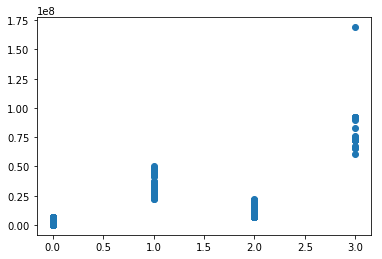

In [3]:
## try and prep data to run through a deep neural net classifier to predict 
#"category" of cheap, medium cheap, expensive, real expensive sales prices
#categories created form a kmeans clustering of sales prices

#convert saledate to datetime
df['SALE DATE'] =pd.to_datetime(df['SALE DATE'])

#mask to clean data
test1 = df['SALE PRICE'] > 0.0 
test2 = df['GROSS SQUARE FEET'] > 0.0
test3 = ~np.isnan(df['SALE PRICE'])
test4 = ~np.isnan(df['GROSS SQUARE FEET'])
test = test1 & test2 & test3 & test4

#data to keep for classifier
paramlist = ['RESIDENTIAL UNITS','COMMERCIAL UNITS','TOTAL UNITS','LAND SQUARE FEET',
                    'GROSS SQUARE FEET','YEAR BUILT','long','lat']

#partition features and inputs
#first shuffle the data
df = df.sample(frac=1)
df = df.loc[test,:]
df_dat = df.loc[:,paramlist]

#create labels. bin prices into 4 categories using k-means
nclasses = 4
prices = df['SALE PRICE']
kmeans = KMeans(n_clusters=nclasses, random_state=0).fit(np.array(prices).reshape(-1, 1))
labels = pd.Series(kmeans.labels_)
#check and see what the categories are like. if they overlap. they do, especially 3
plt.scatter(labels,prices)
plt.show()

#rename features to fit in namescope
df_dat = df_dat.rename(index=str, columns={"RESIDENTIAL UNITS": "resunits", 
                                     "COMMERCIAL UNITS": "communits",
                                    "TOTAL UNITS":"totalunits",
                                    "LAND SQUARE FEET":"landsquarefeet",
                                    "GROSS SQUARE FEET":"grosssquarefeet",
                                    "YEAR BUILT":"yearbuilt",
                                    "SALE DATE":"saledate"})

#partition into training and testing data
n = len(df_dat)
fractrain = 0.8
fractest = 1-fractrain

train_dat = df_dat.iloc[0:int(np.floor(fractrain*n)),:]
train_labels = labels[0:int(np.floor(fractrain*n))]
test_dat = df_dat.iloc[int(np.floor(fractrain*n))+1:]
test_labels = labels[int(np.floor(fractrain*n))+1:]


In [4]:
#perform training

batchsize = 500 #number of trials per training batch
nsteps = 1000

# Feature columns describe how to use the input.
my_feature_columns = []
for key in train_dat.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
    
def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)
    # Return the dataset.
    return dataset


input_fn=lambda:train_input_fn(train_dat, train_labels,
                                             batchsize)

# Build 2 hidden layer DNN with 10, 10 units respectively.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 10 nodes each.
    hidden_units=[10, 10],
    # The model must choose between 4 classes.
    n_classes=nclasses)

# Train the Model.
classifier.train(input_fn,steps=nsteps)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/_x/hjcw_nn146jgqk4lp69ghtxr0000gn/T/tmpfr65l8h2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11495c0b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Calling mode

In [5]:
#check performance
def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features=dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the dataset.
    return dataset

  # Evaluate the model.
eval_result = classifier.evaluate(
   input_fn=lambda:eval_input_fn(test_dat, test_labels,
                                100))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-22T14:35:44Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /var/folders/_x/hjcw_nn146jgqk4lp69ghtxr0000gn/T/tmpfr65l8h2/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-22-14:35:45
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.9649474, average_loss = 0.5078569, global_step = 1000, loss = 50.70951
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /var/folders/_x/hjcw_nn146jgqk4lp69ghtxr0000gn/T/tmpfr65l8h2/model.ckpt-1000


In [7]:
#examine the individual predictions of the test data and compare to true class
predict_x = test_dat
expected = np.array(test_labels)
#print(expected)

predictions = classifier.predict(
        input_fn=lambda:eval_input_fn(predict_x,
        labels=None,batch_size=1))

test = list(predictions)
for k in range(len(test)):
    print('expected: ' +str(expected[k])+ '. predicted: '+str(test[k]['class_ids'])+ '. probs:' + str(test[k]['probabilities']))


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/_x/hjcw_nn146jgqk4lp69ghtxr0000gn/T/tmpfr65l8h2/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
expected: 2. predicted: [2]. probs:[0. 0. 1. 0.]
expected: 0. predicted: [0]. probs:[1.0000000e+00 0.0000000e+00 5.4365474e-18 0.0000000e+00]
expected: 0. predicted: [0]. probs:[1.000000e+00 0.000000e+00 4.721937e-23 0.000000e+00]
expected: 0. predicted: [0]. probs:[0.90475893 0.0155604  0.07731609 0.00236449]
expected: 0. predicted: [0]. probs:[1.000000e+00 0.000000e+00 3.507684e-36 0.000000e+00]
expected: 0. predicted: [0]. probs:[1.0000000e+00 0.0000000e+00 2.1743441e-35 0.0000000e+00]
expected: 0. predicted: [0]. probs:[1.0000000e+00 0.0000000e+00 1.0895268e-29 0.0000000e+00]
expected: 0. predicted: [0]. probs:[1.000000e+00 0.000000e+00 4.049085e-30 0.000000e+00]
expected: 0.

expected: 0. predicted: [0]. probs:[1.000000e+00 0.000000e+00 1.458758e-17 0.000000e+00]
expected: 0. predicted: [0]. probs:[1.000000e+00 0.000000e+00 4.993064e-33 0.000000e+00]
expected: 0. predicted: [0]. probs:[1.0000000e+00 0.0000000e+00 1.0969107e-32 0.0000000e+00]
expected: 0. predicted: [0]. probs:[1.000000e+00 0.000000e+00 5.683216e-32 0.000000e+00]
expected: 0. predicted: [0]. probs:[1.0000000e+00 0.0000000e+00 2.1794257e-28 0.0000000e+00]
expected: 0. predicted: [0]. probs:[1.0000000e+00 2.7017915e-31 1.3308391e-13 0.0000000e+00]
expected: 0. predicted: [0]. probs:[1.0000000e+00 0.0000000e+00 6.8547213e-31 0.0000000e+00]
expected: 0. predicted: [0]. probs:[1.000000e+00 0.000000e+00 1.914361e-37 0.000000e+00]
expected: 0. predicted: [0]. probs:[1.000000e+00 0.000000e+00 2.214512e-31 0.000000e+00]
expected: 0. predicted: [0]. probs:[1.0000000e+00 0.0000000e+00 5.4437114e-24 0.0000000e+00]
expected: 0. predicted: [0]. probs:[1.000000e+00 0.000000e+00 3.284919e-31 0.000000e+00]
e

expected: 0. predicted: [0]. probs:[1.0000000e+00 1.7355589e-32 5.0132668e-14 0.0000000e+00]
expected: 0. predicted: [0]. probs:[1. 0. 0. 0.]
expected: 0. predicted: [0]. probs:[1.0000000e+00 0.0000000e+00 1.3635318e-29 0.0000000e+00]
expected: 0. predicted: [0]. probs:[1.0000000e+00 0.0000000e+00 4.6914182e-29 0.0000000e+00]
expected: 0. predicted: [0]. probs:[1.0000000e+00 0.0000000e+00 1.2133255e-34 0.0000000e+00]
expected: 0. predicted: [0]. probs:[9.9977154e-01 1.3765183e-08 5.5726330e-05 1.7269312e-04]
expected: 0. predicted: [0]. probs:[1.0000000e+00 0.0000000e+00 8.1508804e-29 0.0000000e+00]
expected: 0. predicted: [0]. probs:[0.9188101  0.01197774 0.06765115 0.0015609 ]
expected: 0. predicted: [0]. probs:[1.000000e+00 0.000000e+00 6.069382e-38 0.000000e+00]
expected: 0. predicted: [0]. probs:[0.89091474 0.01937164 0.08636141 0.00335228]
expected: 0. predicted: [0]. probs:[1. 0. 0. 0.]
expected: 0. predicted: [0]. probs:[9.3868625e-01 6.6677625e-03 5.3984649e-02 6.6131953e-04]
